In [1]:
!pip install nltk gensim --quiet

In [2]:
!pip install tqdm --quiet

In [3]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import os 
import torch
import re 
import nltk 

from tensorflow.keras.layers import Dense, Input, Conv2D, LSTM, Bidirectional, Flatten, MaxPool2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from transformers import BertTokenizer, TFBertModel
from gensim.utils import simple_preprocess
from math import ceil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class PrepareModel:
    def __init__(self, 
                 dataset_raw_train: pd.DataFrame, 
                 dataset_raw_test: pd.DataFrame, 
                 save_path: str, 
                 labels: list[str] = ['FAKE', 'REAL']):
        self.raw_train_dataset = dataset_raw_train
        self.raw_test_dataset = dataset_raw_test
        self.save_path = save_path
        
        self.bert_tokenizer = None 
        self.bert_model = None 
        self.train_history = {}
        
        self.bert_dense_model = None 
        self.bert_lstm_model = None 
        self.bert_bilstm_model = None 
        self.bert_cnn_model = None 
        
        self.MAX_SEQ_LENGTH = 256
        self.EPOCHS = 10
        self.MODEL_TYPE = ['dense', 'lstm', 'bilstm', 'cnn']
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.LABELS = labels
        self.model_name = "bert-base-uncased"
        self.embed_len = 768
        
        nltk.download("stopwords")
        self.stop_words = set(nltk.corpus.stopwords.words("english"))
        
    def prepare_dataset(self):
        print("Training Dataset - ", self.raw_train_dataset.iloc[:, 1].value_counts())
        self.X_train_raw = self.raw_train_dataset.iloc[:, 0].tolist()
        y_train_raw = self.raw_train_dataset.iloc[:, 1].replace(self.LABELS, [0, 1]).tolist()
        
        self.y_train_raw = [[0, 0] for _ in range(len(y_train_raw))]
        for i, j in enumerate(y_train_raw):
            self.y_train_raw[i][j] = 1
        self.y_train_raw = np.array(self.y_train_raw, dtype=np.float32)
        
        print("Train data shape - ", self.raw_train_dataset.shape)
        
        print("Test Dataset - ", self.raw_test_dataset.iloc[:, 1].value_counts())
        self.X_test_raw = self.raw_test_dataset.iloc[:, 0].tolist()
        y_test_raw = self.raw_test_dataset.iloc[:, 1].replace(self.LABELS, [0, 1]).tolist()
        
        self.y_test_raw = [[0, 0] for _ in range(len(y_test_raw))]
        for i, j in enumerate(y_test_raw):
            self.y_test_raw[i][j] = 1
        self.y_test_raw = np.array(self.y_test_raw, dtype=np.float32)
        
        print("Test data shape - ", self.raw_test_dataset.shape)
        
    def prepare_bert_tokens(self):
        if not self.bert_model or not self.bert_tokenizer:
            self.bert_tokenizer, self.bert_model = self.load_bert_model()
            print("Loaded bert Tokenizer and Model.")
        else:
            print("bert Model and Tokenizer already loaded.")
        
        self.X_train_bert_tokens = self.get_bert_tokens(
            self.X_train_raw 
        )
        
        self.X_test_bert_tokens = self.get_bert_tokens(
            self.X_test_raw 
        )
        
        print("bert Tokens prepared.")
        
    def load_bert_model(self):
        tokenizer = BertTokenizer.from_pretrained(self.model_name)
        model = TFBertModel.from_pretrained(self.model_name)
        model.trainable = False
        
        return tokenizer, model
    
    def save_bert_tokens(self):
        os.makedirs(self.save_path+"/Tokens/bert/", exist_ok=True)
        
        np.savez(self.save_path + "/Tokens/bert/tokens.npz",
                 train_bert=self.X_train_bert_tokens, 
                 test_bert=self.X_test_bert_tokens)
        
        print("Embeddings saved at path - {}".format(self.save_path + "/Tokens/bert/tokens.npz"))
    
    def load_bert_tokens(self, path=None):
        if path is None:
            numpy_file = np.load(self.save_path + "/Tokens/bert/tokens.npz")
        else: 
            numpy_file = np.load(path, allow_pickle=True)
            
        self.X_train_bert_tokens = numpy_file['train_bert']
        self.X_test_bert_tokens = numpy_file['test_bert']

        print("bert Embeddings successfully loaded.")
        
    def save_labels(self):
        os.makedirs(self.save_path + "/Tokens/bert-Labels/", exist_ok=True)
        np.savez(self.save_path + "/Tokens/bert-Labels/label.npz",
                 train=self.y_train_raw, test=self.y_test_raw)
        
        print("Labels saved at path - {}".format(self.save_path + "/Tokens/bert-Labels/label.npz"))
        
    def load_labels(self, path=None):
        if path is None:
            numpy_file = np.load(self.save_path + "/Tokens/bert-Labels/label.npz")
        else:
            numpy_file = np.load(path, allow_pickle=True)
        
        self.y_train_raw = numpy_file['train']
        self.y_test_raw = numpy_file['test']
        
        print("Labels successfully loaded.")
    
    def train_dense_model(self, layers: int = 3, units: int = 200):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        for _ in range(layers):
            x = Dense(units, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(2, activation='softmax')(x)
        self.bert_dense_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids],
                                                        outputs=x)
                
        self.bert_dense_model.compile(loss='binary_crossentropy', 
                                        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                        metrics=['accuracy'])
                
        print("Model compiled with summary ----- ")
        print(self.bert_dense_model.summary())
                
        self.train_history['bert_dense'] = self.bert_dense_model.fit(self.X_train_bert_tokens, 
                                                                        self.y_train_raw,
                                                                        epochs=self.EPOCHS)
    
    def train_lstm_model(self, layers: int = 3, units: int = 64):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        for _ in range(layers-1):
            x = LSTM(units, return_sequences=True)(x)
        x = LSTM(units)(x)
        x = Dense(units, activation='relu')(x)
        x = Dense(2, activation='softmax')(x)
        self.bert_lstm_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                        outputs=x)
                
        self.bert_lstm_model.compile(loss='binary_crossentropy', 
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                                    metrics=['accuracy'])
                
        self.train_history['bert_lstm'] = self.bert_lstm_model.fit(self.X_train_bert_tokens, 
                                                                    self.y_train_raw, 
                                                                    epochs=self.EPOCHS, 
                                                                    )
                
        print("Model compiles with summary ----- ")
        print(self.bert_lstm_model.summary())
 
    
    def train_bilstm_model(self, layers: int = 3, units: int = 64):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        for _ in range(layers-1):
            x = Bidirectional(LSTM(units, return_sequences=True))(x)
        x = Bidirectional(LSTM(units))(x)
        x = Dense(units, activation='relu')(x)
        x = Dense(2, activation='softmax')(x)
        self.bert_bilstm_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                        outputs=x)
                
        self.bert_bilstm_model.compile(loss='binary_crossentropy', 
                                        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                                        metrics=['accuracy'])
                
        self.train_history['bert_bilstm'] = self.bert_bilstm_model.fit(self.X_train_bert_tokens, 
                                                                    self.y_train_raw, 
                                                                    epochs=self.EPOCHS, 
                                                                    )
                
        print("Model compiles with summary ----- ")
        print(self.bert_bilstm_model.summary())

    
    def train_cnn_model(self, units: int = 512):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        x = tf.keras.layers.Reshape((self.MAX_SEQ_LENGTH, self.embed_len, 1))(x)
        x = Conv2D(units, kernel_size=(3, self.embed_len), padding='valid', 
                    kernel_initializer='normal', activation='relu')(x)
        x = tf.keras.layers.MaxPool2D((2, 1), (2, 1))(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units)(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(2, activation='softmax')(x)
                
        self.bert_cnn_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                        outputs=x)
                
        self.bert_cnn_model.compile(loss='binary_crossentropy', 
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                                    metrics=['accuracy'])
                
        print("Model compiles with summary ----- ")
        print(self.bert_cnn_model.summary())
                
        self.train_history['bert_cnn'] = self.bert_cnn_model.fit(self.X_train_bert_tokens, 
                                                                    self.y_train_raw, 
                                                                    epochs=self.EPOCHS, 
                                                                    )
            
    def train_cnn_bilstm(self):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        
        reshape_layer = tf.keras.layers.Reshape((self.MAX_SEQ_LENGTH, self.embed_len, 1))(x)
        cnn_layer = Conv2D(128, kernel_size=(3, self.embed_len), padding='valid', 
                           kernel_initializer='normal', activation='relu')(reshape_layer)
        pool_layer = MaxPool2D((2, 1), strides=(2, 1), 
                               padding='valid')(cnn_layer)
        flatten_0 = Flatten()(pool_layer)
        
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(x)
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(bilstm_layer)
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(bilstm_layer)
        flatten_1 = Flatten()(bilstm_layer)
        
        merged_layer = tf.keras.layers.Concatenate(axis=1)([flatten_0, flatten_1])
        dense_layer = Dense(512, activation='relu')(merged_layer)
        dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
        output_layer = Dense(2, activation='softmax')(dropout_layer)
        
        self.cnn_bilstm_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                      outputs=output_layer)
        
        self.cnn_bilstm_model.compile(loss='binary_crossentropy', 
                                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                      metrics=['accuracy'])
        
        print("Model compiled with summary ----")
        print(self.cnn_bilstm_model.summary())
        
        self.cnn_bilstm_model.fit(self.X_train_bert_tokens, self.y_train_raw, 
                                  epochs=self.EPOCHS)
        
    def train_multi_cnn(self):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        reshape_layer = tf.keras.layers.Reshape((self.MAX_SEQ_LENGTH, self.embed_len, 1))(x)
        
        cnn_1 = Conv2D(128, kernel_size=(2, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_2 = Conv2D(128, kernel_size=(3, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_3 = Conv2D(128, kernel_size=(4, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_4 = Conv2D(128, kernel_size=(5, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        
        pool_1 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_1)
        pool_2 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_2)
        pool_3 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_3)
        pool_4 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_4)
        
        merged_layer = tf.keras.layers.Concatenate(axis=1)([pool_1, pool_2, pool_3, pool_4])
        flatten_layer = Flatten()(merged_layer)
        dense_layer = Dense(512, activation='relu')(flatten_layer)
        dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
        output_layer = Dense(2, activation='softmax')(dropout_layer)
        
        self.multi_cnn_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                     outputs=output_layer)
        self.multi_cnn_model.compile(loss='binary_crossentropy', 
                                     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                                     metrics=['accuracy'])
        
        print("Model compiled with summary ----")
        print(self.multi_cnn_model.summary())
        
        self.multi_cnn_model.fit(self.X_train_bert_tokens, self.y_train_raw, 
                                 epochs=self.EPOCHS)
        
    def train_multi_cnn_bilstm(self):
        input_word_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(self.MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_type_ids')
        x = self.bert_model.bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)
        x = x[0]
        reshape_layer = tf.keras.layers.Reshape((self.MAX_SEQ_LENGTH, self.embed_len, 1))(x)
        
        cnn_1 = Conv2D(128, kernel_size=(2, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_2 = Conv2D(128, kernel_size=(3, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_3 = Conv2D(128, kernel_size=(4, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        cnn_4 = Conv2D(128, kernel_size=(5, self.embed_len), padding='valid', 
                       kernel_initializer='normal', activation='relu')(reshape_layer)
        
        pool_1 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_1)
        pool_2 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_2)
        pool_3 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_3)
        pool_4 = MaxPool2D((2, 1), strides=(2, 1), 
                           padding='valid')(cnn_4)
        
        merged_0 = tf.keras.layers.Concatenate(axis=1)([pool_1, pool_2, pool_3, pool_4])
        flatten_0 = Flatten()(merged_0)
        
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(x)
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(bilstm_layer)
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(bilstm_layer)
        flatten_1 = Flatten()(bilstm_layer)
        
        merged_layer = tf.keras.layers.Concatenate(axis=1)([flatten_0, flatten_1])
        dense_layer = Dense(512, activation='relu')(merged_layer)
        dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
        output_layer = Dense(2, activation='softmax')(dropout_layer)
        
        self.multi_cnn_bilstm_model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                                                            outputs=output_layer)
        self.multi_cnn_bilstm_model.compile(loss='binary_crossentropy', 
                                     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                                     metrics=['accuracy'])
        
        print("Model compiled with summary ----")
        print(self.multi_cnn_bilstm_model.summary())
        
        self.multi_cnn_bilstm_model.fit(self.X_train_bert_tokens, self.y_train_raw, 
                                 epochs=self.EPOCHS)
    
    def save_model(self, model, filename: str):
        dir = self.save_path + "/Models-bert/" + filename
        os.makedirs(self.save_path + "/Models-bert/", exist_ok=True)
        try:
            model.save(dir)
            print("Successfully saved model at - ", dir)
        except Exception as e:
            print('There was an error saving model at - ', dir)
            print(e)
            
    def load_model(self, filepath: str):
        try:
            model = tf.keras.models.load_model(filepath)
            print("Loaded model {} from path {}".format(model, filepath))
            print("Summary - {}".format(model.summary()))
            
            return model
        except Exception as e:
            print(e)
    
    def evaluate_model(self, model):
        try:
            y_test = self.y_test_raw
            y_pred = np.round(model.predict(self.X_test_bert_tokens))
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test[:, 0], y_pred[:, 0])
            recall = recall_score(y_test[:, 0], y_pred[:, 0])
            f1 = f1_score(y_test[:, 0], y_pred[:, 0])
            roc_auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])
            
            print("Accuracy - ", accuracy)
            print("Precision - ", precision)
            print("Recall - ", recall)
            print("F1 - ", f1)
            print("Roc-Auc - ", roc_auc)
            
            return accuracy, precision, recall, f1, roc_auc
        except Exception as e:
            print(e)
    
    def get_bert_tokens(self, texts):
        texts = [self.seq_preprocess(seq) for seq in texts]
        ct = len(texts)
        input_ids = np.ones((ct, self.MAX_SEQ_LENGTH), dtype='int32')
        attention_mask = np.zeros((ct, self.MAX_SEQ_LENGTH), dtype='int32')
        token_type_ids = np.zeros((ct, self.MAX_SEQ_LENGTH), dtype='int32')

        for k, text in tqdm(enumerate(texts), total=len(texts)):
            # Tokenize
            tok_text = self.bert_tokenizer.tokenize(text)

            # Truncate and convert tokens to numerical IDs
            enc_text = self.bert_tokenizer.convert_tokens_to_ids(tok_text[:(self.MAX_SEQ_LENGTH-2)])

            input_length = len(enc_text) + 2
            input_length = input_length if input_length < self.MAX_SEQ_LENGTH else self.MAX_SEQ_LENGTH

            # Add tokens [CLS] and [SEP] at the beginning and the end
            input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

            # Set to 1s in the attention input
            attention_mask[k,:input_length] = 1


        return {
            'input_word_ids': tf.constant(input_ids),
            'input_mask': tf.constant(attention_mask),
            'input_type_ids': tf.constant(token_type_ids)
        }
    
    def seq_preprocess(self, sequence: str):
        processed_words = simple_preprocess(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", sequence))
        processed_words = [word.lower() for word in processed_words if word.lower() not in self.stop_words]
        
        return ' '.join(processed_words)

In [5]:
from sklearn.model_selection import train_test_split

dataset_a = pd.read_csv("/kaggle/input/dataset-d/WELFake_Dataset.csv")
dataset_a.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
dataset_a = dataset_a[['text', 'label']]
dataset_a.dropna(inplace=True)

In [7]:
dataset_a.shape

(72095, 2)

In [8]:
dataset_a['label'].value_counts()

label
1    37067
0    35028
Name: count, dtype: int64

In [9]:
!pip install matplotlib seaborn --quiet

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sequence_word_counts(sequences):
    word_counts = [len(sequence.split()) for sequence in sequences]

    min_length_index = word_counts.index(min(word_counts))
    max_length_index = word_counts.index(max(word_counts))

    print("Sequence with minimum length:", len(sequences[min_length_index]), " - index: ", min_length_index)
    print("Sequence with maximum length:", len(sequences[max_length_index]), " - index: ", max_length_index)
    print("Sequence average length: ", sum(word_counts)/len(sequences))

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=20, kde=False, color="skyblue")
    
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title("Histogram of Word Counts for Sequences")
    plt.show()

Sequence with minimum length: 1  - index:  7
Sequence with maximum length: 134206  - index:  327
Sequence average length:  540.8433455856856


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


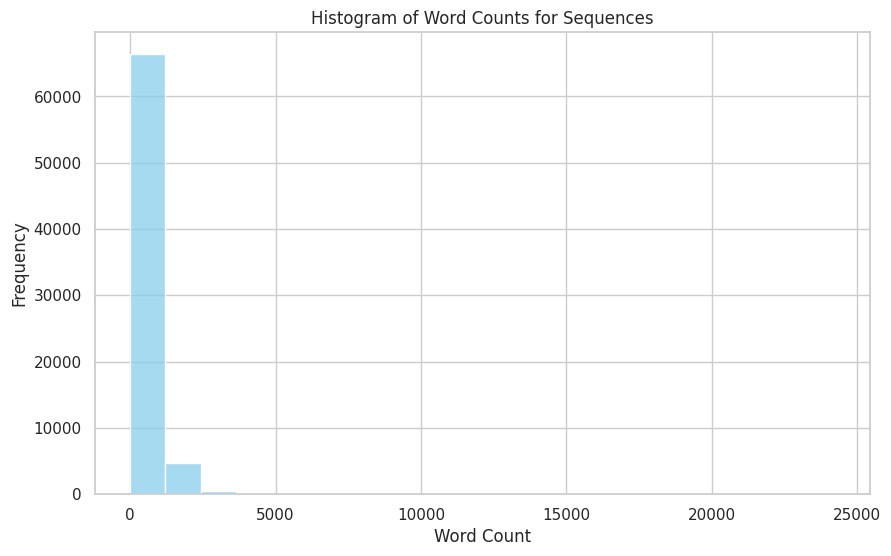

In [11]:
plot_sequence_word_counts(dataset_a['text'].tolist())

In [12]:
train_df, test_df = train_test_split(dataset_a, test_size=0.2, random_state=42)

In [13]:
train_df.to_csv("dataset-d-train.csv")
test_df.to_csv("dataset-d-test.csv")

In [14]:
model_class = PrepareModel(train_df, test_df, "Dataset-D")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
model_class.prepare_dataset()

Training Dataset -  label
1    29658
0    28018
Name: count, dtype: int64
Train data shape -  (57676, 2)
Test Dataset -  label
1    7409
0    7010
Name: count, dtype: int64
Test data shape -  (14419, 2)


In [16]:
%%time
model_class.prepare_bert_tokens()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loaded bert Tokenizer and Model.


100%|██████████| 14419/14419 [03:18<00:00, 72.49it/s]

bert Tokens prepared.
CPU times: user 19min 29s, sys: 5.27 s, total: 19min 35s
Wall time: 19min 34s


In [17]:
model_class.save_bert_tokens()

Embeddings saved at path - Dataset-D/Tokens/bert/tokens.npz


In [18]:
model_class.save_labels()

Labels saved at path - Dataset-D/Tokens/bert-Labels/label.npz


In [19]:
%%time
model_class.train_dense_model(units=256)

Model compiled with summary ----- 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                           

In [20]:
model_class.save_model(model_class.bert_dense_model, "bert-dense")

Successfully saved model at -  Dataset-D/Models-bert/bert-dense


In [21]:
%%time
model_class.train_lstm_model(units=128)

Epoch 1/10
1803/1803 [==============================] - 719s 389ms/step - loss: 0.4534 - accuracy: 0.7879
Epoch 2/10
1803/1803 [==============================] - 701s 389ms/step - loss: 0.3812 - accuracy: 0.8340
Epoch 3/10
1803/1803 [==============================] - 700s 388ms/step - loss: 0.3398 - accuracy: 0.8547
Epoch 4/10
1803/1803 [==============================] - 699s 388ms/step - loss: 0.2952 - accuracy: 0.8752
Epoch 5/10
1803/1803 [==============================] - 700s 388ms/step - loss: 0.2638 - accuracy: 0.8885
Epoch 6/10
1803/1803 [==============================] - 699s 388ms/step - loss: 0.2453 - accuracy: 0.8958
Epoch 7/10
1803/1803 [==============================] - 699s 388ms/step - loss: 0.2282 - accuracy: 0.9033
Epoch 8/10
1803/1803 [==============================] - 699s 388ms/step - loss: 0.2192 - accuracy: 0.9073
Epoch 9/10
1803/1803 [==============================] - 700s 388ms/step - loss: 0.2101 - accuracy: 0.9110
Epoch 10/10
1803/1803 [=======================

In [22]:
model_class.save_model(model_class.bert_lstm_model, "bert-lstm")

Successfully saved model at -  Dataset-D/Models-bert/bert-lstm


In [23]:
model_class.train_bilstm_model(units=128)

Epoch 1/10
1803/1803 [==============================] - 810s 436ms/step - loss: 0.3340 - accuracy: 0.8504
Epoch 2/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.2672 - accuracy: 0.8833
Epoch 3/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.2400 - accuracy: 0.8956
Epoch 4/10
1803/1803 [==============================] - 785s 436ms/step - loss: 0.2269 - accuracy: 0.9026
Epoch 5/10
1803/1803 [==============================] - 785s 435ms/step - loss: 0.2128 - accuracy: 0.9092
Epoch 6/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.2001 - accuracy: 0.9155
Epoch 7/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.1897 - accuracy: 0.9202
Epoch 8/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.1826 - accuracy: 0.9240
Epoch 9/10
1803/1803 [==============================] - 786s 436ms/step - loss: 0.1752 - accuracy: 0.9269
Epoch 10/10
1803/1803 [=======================

In [24]:
model_class.save_model(model_class.bert_bilstm_model, "bert-bilstm")

Successfully saved model at -  Dataset-D/Models-bert/bert-bilstm


In [25]:
model_class.train_cnn_model(units=128)

Model compiles with summary ----- 
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                         

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1803/1803 [==============================] - 629s 349ms/step - loss: 0.2569 - accuracy: 0.8917
Epoch 4/10
1803/1803 [==============================] - 629s 349ms/step - loss: 0.2373 - accuracy: 0.8996
Epoch 5/10
1803/1803 [==============================] - 631s 350ms/step - loss: 0.2227 - accuracy: 0.9076
Epoch 6/10
1803/1803 [==============================] - 632s 351ms/step - loss: 0.2081 - accuracy: 0.9132
Epoch 7/10
1803/1803 [==============================] - 632s 351ms/step - loss: 0.1969 - accuracy: 0.9202
Epoch 8/10
1803/1803 [==============================] - 633s 351ms/step - loss: 0.1883 - accuracy: 0.9225
Epoch 9/10
1803/1803 [==============================] - 633s 351ms/step - loss: 0.1784 - accuracy: 0.9254
Epoch 10/10
1803/1803 [==============================] - 633s 351ms/step - loss: 0.1707 - accuracy: 0.9309


In [26]:
model_class.save_model(model_class.bert_cnn_model, "bert-cnn")

Successfully saved model at -  Dataset-D/Models-bert/bert-cnn


In [27]:
print("\n---- bert CNN ----\n")
model_class.evaluate_model(model_class.bert_cnn_model)
print("\n---- bert DENSE ----\n")
model_class.evaluate_model(model_class.bert_dense_model)
print("\n---- bert LSTM ----\n")
model_class.evaluate_model(model_class.bert_lstm_model)
print("\n---- bert BILSTM ----\n")
model_class.evaluate_model(model_class.bert_bilstm_model)


---- bert CNN ----

451/451 [==============================] - 147s 319ms/step
Accuracy -  0.9168458284208336
Precision -  0.8875550220088035
Recall -  0.9492154065620542
F1 -  0.9173502447094506
Roc-Auc -  0.9177174346887744

---- bert DENSE ----

451/451 [==============================] - 149s 323ms/step
Accuracy -  0.9332824745127957
Precision -  0.9462809917355371
Recall -  0.9146932952924394
F1 -  0.9302190628173509
Roc-Auc -  0.9327819290607156

---- bert LSTM ----

451/451 [==============================] - 156s 338ms/step
Accuracy -  0.9190651224079339
Precision -  0.9168212298473392
Recall -  0.9166904422253923
F1 -  0.9167558313717099
Roc-Auc -  0.919001180081518

---- bert BILSTM ----

451/451 [==============================] - 167s 360ms/step
Accuracy -  0.926347180803107
Precision -  0.9160604364857303
Recall -  0.9340941512125535
F1 -  0.9249894052832321
Roc-Auc -  0.9265557812345667


(0.926347180803107,
 0.9160604364857303,
 0.9340941512125535,
 0.9249894052832321,
 0.9265557812345667)

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def confusion_matrix_(model):
    predictions = np.round(model.predict(model_class.X_test_bert_tokens))[:, 0]
    y_true = model_class.y_test_raw[:, 0]

    cm = confusion_matrix(y_true, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

bert DENSE ----
451/451 [==============================] - 145s 323ms/step


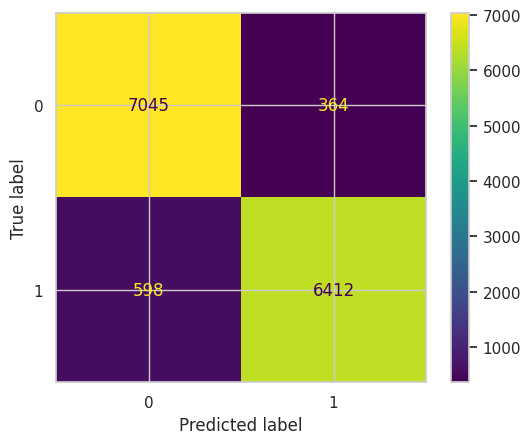

bert LSTM ----
451/451 [==============================] - 152s 338ms/step


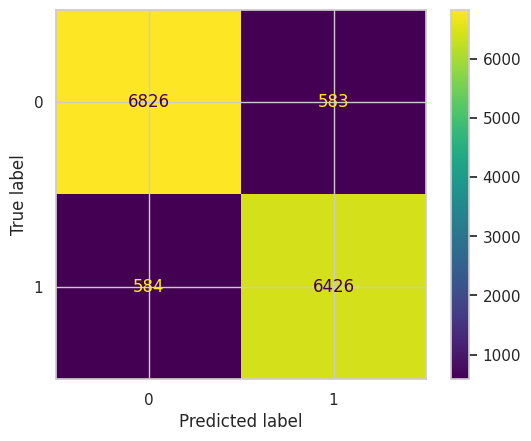

bert BILSTM ---
451/451 [==============================] - 162s 360ms/step


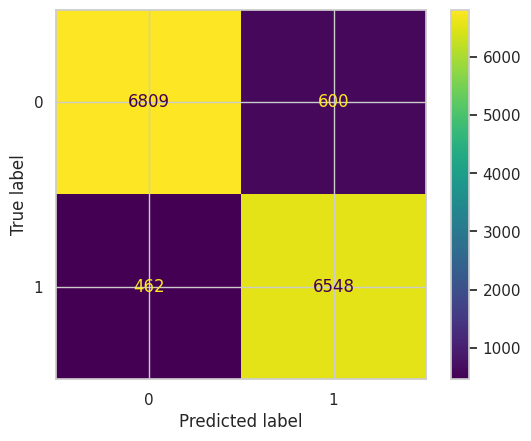

bert CNN ---
451/451 [==============================] - 144s 319ms/step


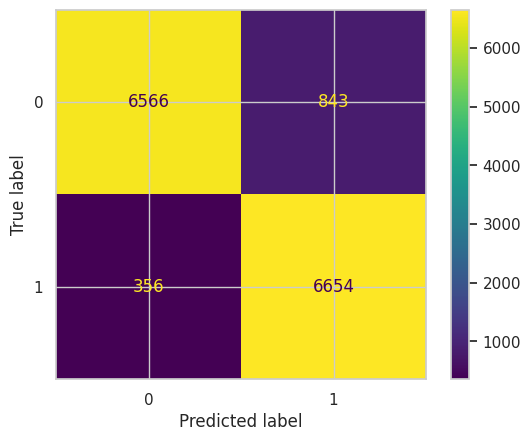

In [29]:
print("bert DENSE ----")
confusion_matrix_(model_class.bert_dense_model)
print("bert LSTM ----")
confusion_matrix_(model_class.bert_lstm_model)
print("bert BILSTM ---")
confusion_matrix_(model_class.bert_bilstm_model)
print("bert CNN ---")
confusion_matrix_(model_class.bert_cnn_model)

In [30]:
# model_class.train_cnn_bilstm()

In [31]:
# model_class.save_model(model_class.cnn_bilstm_model, "cnn-bilstm")

In [32]:
# model_class.evaluate_model(model_class.cnn_bilstm_model)

In [33]:
# confusion_matrix_(model_class.cnn_bilstm_model)

In [34]:
# model_class.train_multi_cnn()

In [35]:
# model_class.save_model(model_class.multi_cnn_model, "multi-cnn")

In [36]:
# model_class.evaluate_model(model_class.multi_cnn_model)

In [37]:
# confusion_matrix_(model_class.multi_cnn_model)

In [38]:
# model_class.train_multi_cnn_bilstm()

In [39]:
# model_class.save_model(model_class.multi_cnn_bilstm_model, "multli-cnn-bilstm")

In [40]:
# model_class.evaluate_model(model_class.multi_cnn_bilstm_model)

In [41]:
# confusion_matrix_(model_class.multi_cnn_bilstm_model)

In [42]:
def display_mcs(raw_dataset, model, y_true):
    label_ = ["Real", "Fake"]
    y_pred = np.round(model.predict(model_class.X_test_bert_tokens))[:, 0]
    y_true = y_true[:, 0]
    
    data = {"index": [], "text": [], "prediction": [], "true_label": []}
    for index in tqdm(range(len(raw_dataset))):
        pred = y_pred[index].astype(int)
        true = y_true[index].astype(int)
        
        if pred != true:
            data['index'].append(index)
            data['text'].append(raw_dataset[index])
            data['prediction'].append(label_[pred])
            data['true_label'].append(label_[true])
            
    return pd.DataFrame(data)

In [43]:
dense_mcs = display_mcs(test_df['text'].tolist(), model_class.bert_dense_model, model_class.y_test_raw)
dense_mcs.to_csv("Dense_mcs.csv")

451/451 [==============================] - 146s 323ms/step


100%|██████████| 14419/14419 [00:00<00:00, 247764.87it/s]


In [44]:
lstm_mcs = display_mcs(test_df['text'].tolist(), model_class.bert_lstm_model, model_class.y_test_raw)
lstm_mcs.to_csv("LSTM_mcs.csv")

451/451 [==============================] - 153s 339ms/step


100%|██████████| 14419/14419 [00:00<00:00, 238694.98it/s]


In [45]:
bilstm_mcs = display_mcs(test_df['text'].tolist(), model_class.bert_bilstm_model, model_class.y_test_raw)
bilstm_mcs.to_csv("BILSTM_mcs.csv")

451/451 [==============================] - 163s 361ms/step


100%|██████████| 14419/14419 [00:00<00:00, 244425.33it/s]


In [46]:
cnn_mcs = display_mcs(test_df['text'].tolist(), model_class.bert_cnn_model, model_class.y_test_raw)
cnn_mcs.to_csv("CNN_mcs.csv")

451/451 [==============================] - 144s 319ms/step


100%|██████████| 14419/14419 [00:00<00:00, 243689.61it/s]


In [47]:
# cnn_bilstm_mcs = display_mcs(test_df['text'].tolist(), model_class.cnn_bilstm_model, model_class.y_test_raw)
# cnn_bilstm_mcs.to_csv("CNN_BILSTM_mcs.csv")
# multi_cnn_mcs = display_mcs(test_df['text'].tolist(), model_class.multi_cnn_model, model_class.y_test_raw)
# multi_cnn_mcs.to_csv("Multi_CNN_mcs.csv")
# multi_cnn_bilstm_mcs = display_mcs(test_df['text'].tolist(), model_class.multi_cnn_bilstm_model, model_class.y_test_raw)
# multi_cnn_bilstm_mcs.to_csv("Multi_CNN_BILSTM_mcs.csv")

In [48]:
!zip -r "dataset-d-bert.zip" "/kaggle/working/"

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/BILSTM_mcs.csv (deflated 62%)
  adding: kaggle/working/LSTM_mcs.csv (deflated 61%)
  adding: kaggle/working/dataset-d-train.csv (deflated 61%)
  adding: kaggle/working/Dense_mcs.csv (deflated 61%)
  adding: kaggle/working/CNN_mcs.csv (deflated 61%)
  adding: kaggle/working/dataset-d-test.csv (deflated 61%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/Dataset-D/ (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/ (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/ (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/fingerprint.pb (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/saved_model.pb (deflated 91%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/assets/ (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/variables/ (stored 0%)
  adding: kaggle/working/Dataset-D/Models-bert/bert-dense/var

In [49]:
from IPython.display import FileLink

FileLink('dataset-d-bert.zip')

/kaggle/working/dataset-d-bert.zip